In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from scipy import stats

from stat570 import datasets

failure_stresses = datasets.failure_stresses.load_data()
failure_stresses

,0,1,2,3,4,5,6,7,8,9,10,11,12
Length (mm),,,,,,,,,,,,,
1,2.247,2.640,2.842,2.908,3.099,3.126,3.245,3.328,3.355,3.383,3.572,3.581,3.681
10,1.901,2.132,2.203,2.228,2.257,2.350,2.361,2.396,2.397,2.445,2.454,2.454,2.474
20,1.312,1.314,1.479,1.552,1.700,1.803,1.861,1.865,1.944,1.958,1.966,1.997,2.006
50,1.339,1.434,1.549,1.574,1.589,1.613,1.746,1.753,1.764,1.807,1.812,1.840,1.852


# Choosing Hyperparameters

We want a Gamma distribution such that the mean is 0.5 and $\mathbb{P}\left([0.05,1]\right) = 0.95$.

In [2]:
from scipy import optimize

def get_gamma_hyperparameters(mean, lower=0.05, upper=1, p=0.95):
    """Fits a gamma distribution with P([lower,upper]) = p with specified mean.
    
    Args:
      mean: Desired expectation of distribution.
      lower: Lower bound of interval.
      upper: Upper bound of interval.
      p: The desired probability of the interval.
      
    Returns:
      The shape and rate parameter of desired gamma distribution.
    """    
    assert 0.05 < mean and mean < upper, 'The mean must between lower and upper.'
    
    def compute_probability(k):
        return (stats.gamma.cdf(upper, mean*k, scale=1/k) -
                stats.gamma.cdf(lower, mean*k, scale=1/k))
    
    scaling_factor = optimize.fsolve(
        lambda k: compute_probability(k) - p, 1)[0]
        
    return mean*scaling_factor, scaling_factor

PRIOR_SHAPE, PRIOR_RATE = get_gamma_hyperparameters(0.5)

print('shape={}, rate={}'.format(PRIOR_SHAPE, PRIOR_RATE))

shape=3.634062529831774, rate=7.268125059663548


In [3]:
def compute_posterior(data, shape, rate):
    """Computes the posterior gamma distribution given observed data.
    
    It's expected that the data has exponential distribution with a
    rate paramter that has a gamma prior.
    
    Args:
      data: Observed exponentially-distributed data.
      shape: Prior shape parameter.
      rate: Prior rate paramter.
      
    Returns:
      The shape and rate parameter of the posterior.
    """
    return shape + len(data), rate + np.sum(data)

def summarize_posterior(params):
    shape = params[0]
    rate = params[1]
    return {
        '$a^\\prime$': shape,
        '$b^\\prime$': rate,
        'Mean': shape/rate,
        'Standard error': np.sqrt(shape)/rate,
    }

gamma_posteriors = failure_stresses.apply(
    lambda data: summarize_posterior(compute_posterior(data, PRIOR_SHAPE, PRIOR_RATE)),
    axis=1, result_type='expand')

with open('p2_gamma_posteriors.tex', 'w') as f:
    f.write(gamma_posteriors.reset_index().to_latex(
        index=False, escape=False))

gamma_posteriors

,$a^\prime$,$b^\prime$,Mean,Standard error
Length (mm),,,,
1,16.634063,48.275125,0.344568,0.084484
10,16.634063,37.320125,0.445713,0.109284
20,16.634063,30.025125,0.554005,0.135836
50,16.634063,28.940125,0.574775,0.140928


/usr/lib/python3.5/importlib/_bootstrap.py:222: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
/usr/lib/python3.5/importlib/_bootstrap.py:222: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
/usr/lib/python3.5/importlib/_bootstrap.py:222: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
/usr/lib/python3.5/importlib/_bootstrap.py:222: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
/usr/lib/python3.5/importlib/_bootstrap.py:222: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)


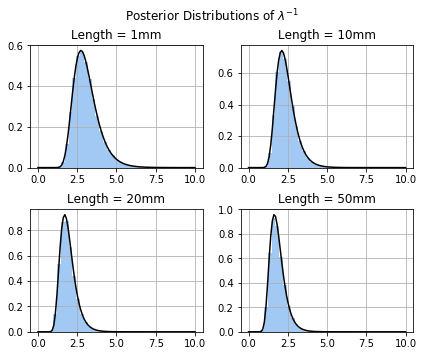

In [4]:
import matplotlib.pyplot as plot
import seaborn as sns

def plot_theoretical_distribution(ax, dist, dist_kws, lower=0, upper=10, bins=42):
    x = np.linspace(lower, upper, num=bins)
    y = dist.cdf(x[1:], **dist_kws) - dist.cdf(x[:-1], **dist_kws)
    x = (x[1:] + x[:-1])/2
    ax.grid(True)
    ax.bar(x, y*len(x)/(upper-lower), width=(upper-lower)/len(x),
           color=sns.color_palette('pastel')[0])
    
    x = np.linspace(lower, upper, num=100)
    ax.plot(x, dist.pdf(x, **dist_kws), '-k')

fig, axes = plt.subplots(figsize=(6,5), ncols=2, nrows=2)

for i, (length, parameters) in enumerate(gamma_posteriors.iterrows()):
    ax = axes[i//2][i % 2]    
    plot_theoretical_distribution(ax, stats.invgamma,
                                  {'a': parameters['$a^\\prime$'], 'scale': parameters['$b^\\prime$']})
    ax.set_title('Length = {}mm'.format(length))
    
fig.suptitle('Posterior Distributions of $\\lambda^{-1}$')
fig.tight_layout()
fig.subplots_adjust(top=0.875)
fig.savefig('p2_posterior_lambda_inverse.pdf', bbox_inches='tight')